In [ ]:
import pdb
import glob
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import drive, data_table
drive.mount('/content/drive', force_remount=True)
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, utils


"""
Autor: Sebastian Carmona Estrada
"""

Mounted at /content/drive


'\nAutor: Sebastian Carmona Estrada\n'

# Funciones axiliares

In [ ]:
def site_location(lat=0, lon=0):
  sites = {(48.44424057006836, -4.4123148918151855): 'Brest', 
           (48.77284622192383, 2.012406349182129): 'Trappes'}
  try:
    return sites[(lat, lon)]
  except:
    return 'Not known site'

def title1(mytitle, coef):
    """
    inclus le titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.95, mytitle, fontsize=6.5*coef, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')
    return


def title2(mytitle, coef):
    """
    inclus le sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.89, mytitle, fontsize=5.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return


def title3(mytitle, coef):
    """
    inclus le sous sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """
    plt.figtext(0.5, 0.85, mytitle, fontsize=4.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return

def gapsizer(ax, time, range, gapsize, colour='#c7c7c7'):
    """
    This function creates a rectangle of color 'colour' when time gap 
    are found in the array 'time'. 
    """
        # search for holes in data
    # --------------------------------------------------------------------
    dif_time = time[1:] - time[0:-1]
    print(type(dif_time))
    for index, delta in enumerate(dif_time):
        # pdb.set_trace()
        if delta > np.timedelta64(gapsize, 'm'):
            # missing hide bad data
            start = mdates.date2num(time[index])
            end = mdates.date2num(time[index + 1])
            width = end - start

            # Plot rectangle
            end = mdates.date2num(time[index + 1])
            rect = mpl.patches.Rectangle(
                (start, 0), width, np.nanmax(range),
                color=colour)
            ax.add_patch(rect)

def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, **kwargs):
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  title1('{instr} {mode} {qt} at {wl} {wlu}'.format(instr=attrs['instrument_id'],
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=2.5)
  title2(str(ds.time.values[0].astype('datetime64[D]')), coef=2.5)

  title3('{} ({:.1f}N, {:.1f}E)'.format(site_location(float(ds.lat.data[0]), float(ds.lon.data[0])), 
                                           float(ds.station_latitude), 
                                           float(ds.station_longitude)), coef=2.5)
  
  q = ds[channel].sel(range=slice(0, 2500)).plot.pcolormesh(x='time', 
                 y='range', 
                 cmap='jet', 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  
  plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0, hspace=0)
  myFmt = mdates.DateFormatter('%H')
  axes.xaxis.set_major_formatter(myFmt)
  

  gapsizer(axes, ds.time.values, ds.range, gapsize=6, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)

def normalize_ds(ds_variable, operation='normalization', vectorize_flag=True):
  def norm(x):
    # pdb.set_trace()
    return (x - x.min()) / (x.max() - x.min())
  def mahalanobis_transform(X):
    # pdb.set_trace()
    cov = np.cov(X, rowvar=False)
    eigenvalues, U = eig(cov)
    Q = eigenvalues * np.identity(cov.shape[0]) 
    gamma = X @ U.T
    std_gamma = np.std(gamma, axis=0)
    mat_ = (1 / std_gamma) * np.identity(cov.shape[0])
    Z = gamma @ mat_
    return Z

  def standar(x):
    return (x - x.mean()) / x.std()

  if vectorize_flag:
    if operation == 'normalization':
      funct_ = np.vectorize(norm, signature='(i)->(i)')
    elif operation == 'standarization':
      funct_ = np.vectorize(standar, signature='(i)->(i)')
    elif operation == 'mahalanobis':
      ds_ = mahalanobis_transform(ds_variable)
      return ds_ 
    ds_ = xr.apply_ufunc(funct_, ds_variable)
  else:
    if operation == 'normalization':
      funct_ = norm
    elif operation == 'standarization':
      funct_ = standar
    elif operation == 'mahalanobis':
      funct_ = mahalanobis_transform

    ds_ = funct_(ds_variable)

  return ds_



In [ ]:
def apply_fft_ds(ds, channel:str='rcs_0', coord_name:str = 'range'):
  """
  Get the numpy fast fourier transform to the lidar profiles and append them to
  the dataset ds.

  Parameters:
  ----------
  ds: xarray.Dataset
    - Dataset to get the np.fft
  channel: str
    - Variable name of the variable to retrieve the np.fft
  coord_name: str
    - Coord name of the coordinate to retrieve de np.fft

  Returns:
  --------
  out: xarray.Dataset
    - Original Dataset ds with the np.fft and the frequencies coord saved.
  """

  coord_units = ds[coord_name].units
  channel_FT = xr.apply_ufunc(np.fft.fft, ds[channel])
  dfreqs = (1/max(ds[coord_name])).data
  out = ds.assign_coords({'freqs': ('freqs', np.arange(0, dfreqs*len(ds[coord_name]), dfreqs), {'units': '1/{}'.format(coord_units), 'long_name': 'frequencies'})})
  out = out.assign({'{}_fft'.format(channel): ({'time':out.time, 'freqs':out.freqs}, channel_FT.data, {'long_name': 'Fast Fourier transform of {}'.format(ds[channel].attrs['long_name'])})})
  # out = out['{}_fft'.format(channel)].assign_coords(freqs=out.freqs)
  # pdb.set_trace()

  return out

def dataarray_magnitude(da):
  """
  Get the magnitude of a xarray.Dataaray da with complex numbers
  """
  out = xr.apply_ufunc(np.real, ds.rcs_0_fft)**2 + xr.apply_ufunc(np.real, ds.rcs_0_fft) **2
  return xr.apply_ufunc(np.sqrt, out)


# Carga de datos

## METEOFRANCE

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20170424.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.out.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5030_20200326.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

<class 'numpy.ndarray'>


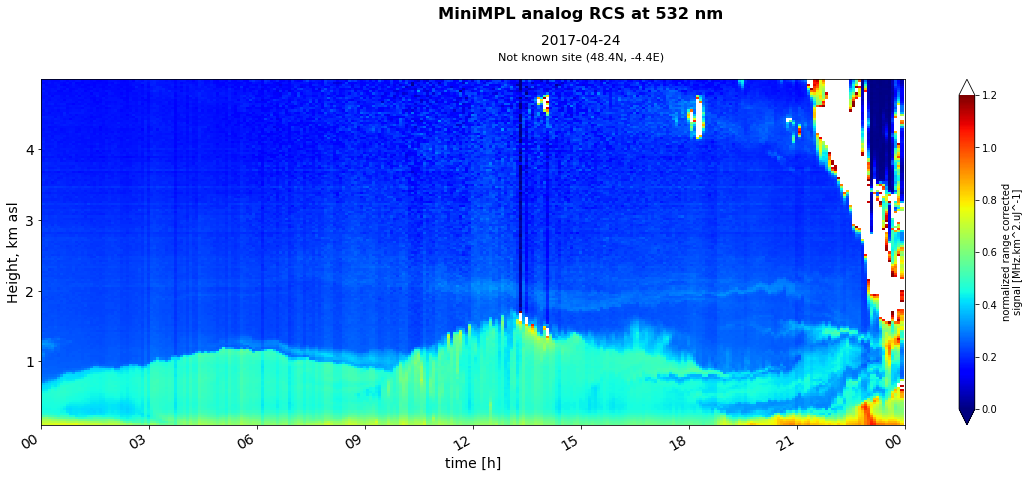

In [ ]:
for filename in [filenames[0]]:
  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.2,
            vmin=0,
            )
  
  

  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)
  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

In [ ]:
filenames = ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc', 
             '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

blh_human_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'
blh_lidar_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-lidar/'

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


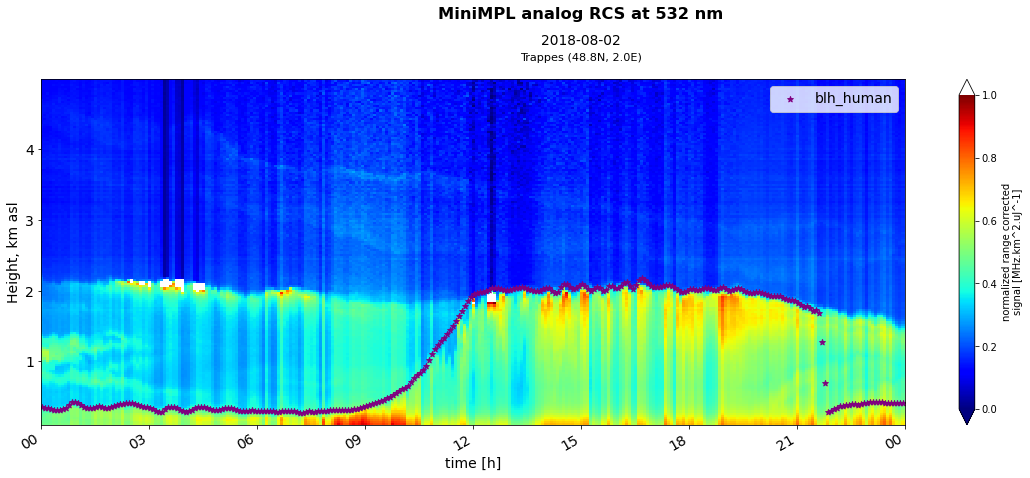

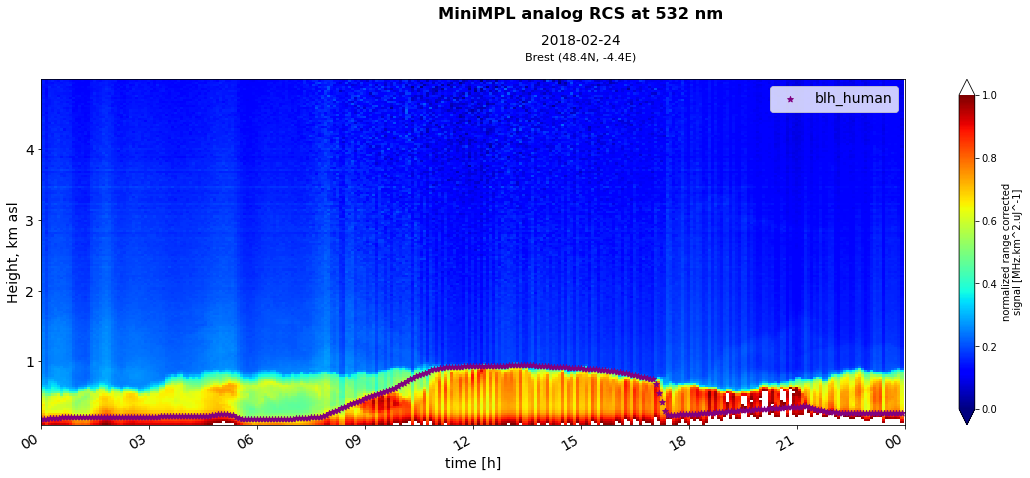

In [ ]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)
  site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.0,
            vmin=0,
            )
  ds.ablh_gm1.plot(x='time')
  blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  blh_human = pd.read_csv(blh_human_filename)
  blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)

  blh_lidar_filename = glob.glob(blh_lidar_path + '*' + site + '*')[0]
  blh_lidar = xr.load_dataset(blh_lidar_filename, decode_times=False)
  blh_lidar.assign_coords(time=[pd.Timestamp.fromtimestamp(date) for date in blh_lidar.time.values])

  # Create Mask
  mask = np.zeros(ds.rcs_0.shape)
  for idx, profile in enumerate(mask):
    mask[idx] = xr.where(ds.range < blh_human['blh_ref'][idx]/1000, 1, 0)
  ds = ds.assign({'abl_mask': (('time', 'range'), mask)})

  plt.scatter(blh_human.t_values, blh_human.blh_ref/1000, c='purple', s=None, marker='*', label='blh_human')
  # blh_lidar.plot.scatter(x='time', y='BLH_INDUS')
  # plt.scatter(blh_lidar.time, blh_lidar.BLH_INDUS)
  plt.legend(fontsize=14)
  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)

# Preprocesado

## LIDAR FOURIER TRANSFORM

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames[-2:]

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

In [ ]:
ds = xr.load_dataset(filenames[0])
ds

<xarray.Dataset>
Dimensions:                           (time: 288, range: 664, range_raw: 1000, range_vbp: 197, layer: 10)
Coordinates:
  * time                              (time) datetime64[ns] 2017-04-24 ... 20...
  * range                             (range) float32 119.9 149.9 ... 2e+04
  * range_raw                         (range_raw) float32 29.98 ... 2.998e+04
  * range_vbp                         (range_vbp) float32 119.9 ... 5.996e+03
  * layer                             (layer) int32 0 1 2 3 4 5 6 7 8 9
Data variables: (12/54)
    rcs_0                             (time, range) float64 0.7166 ... 0.004967
    bckgrd_rcs_0                      (time) float64 0.000581 ... 0.0005982
    rcs_1                             (time, range) float64 0.7009 ... 0.01122
    bckgrd_rcs_1                      (time) float64 0.0003586 ... 0.0003734
    rcs_2                             (time, range) float64 0.01567 ... -0.00...
    bckgrd_rcs_2                      (time) float64 0.000581 ... 0.0005982
    ...                                ...
    pbl                               (time, layer) float32 239.8 nan ... nan
    ext_coeff                         (time, range_vbp) float32 0.05824 ... 0.0
    mass_concentration                (time, range_vbp) float32 0.0 0.0 ... 0.0
    vbp_coeff                         (time, range_vbp) float32 0.001941 ... 0.0
    particle_type                     (time, range) float64 5.0 5.0 ... 7.0 7.0
    rr                                (time) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes: (12/14)
    site_location:                Name of measurement station
    instrument_id:                MiniMPL
    institution:                  The institution or Met Service operating th...
    principal_investigator:       Department responsible for the instrument
    instrument_type:              Mini-MPL
    title:                        the site name and instrument type and manuf...
    ...                           ...
    overlap_function:             False
    overlap_is_corrected:         True
    source:                       SIRTA & UK Met Office
    references:                   
    comment:                      
    Conventions:                  CF-1.0, UKMO-1.0.2

In [ ]:
ds = xr.load_dataset(filenames[0])
ds = apply_fft_ds(ds)
ds

<xarray.Dataset>
Dimensions:                           (time: 288, range: 664, range_raw: 1000, range_vbp: 197, layer: 10, freqs: 664)
Coordinates:
  * time                              (time) datetime64[ns] 2017-04-24 ... 20...
  * range                             (range) float32 119.9 149.9 ... 2e+04
  * range_raw                         (range_raw) float32 29.98 ... 2.998e+04
  * range_vbp                         (range_vbp) float32 119.9 ... 5.996e+03
  * layer                             (layer) int32 0 1 2 3 4 5 6 7 8 9
  * freqs                             (freqs) float64 0.0 5.001e-05 ... 0.03316
Data variables: (12/55)
    rcs_0                             (time, range) float64 0.7166 ... 0.004967
    bckgrd_rcs_0                      (time) float64 0.000581 ... 0.0005982
    rcs_1                             (time, range) float64 0.7009 ... 0.01122
    bckgrd_rcs_1                      (time) float64 0.0003586 ... 0.0003734
    rcs_2                             (time, range) float64 0.01567 ... -0.00...
    bckgrd_rcs_2                      (time) float64 0.000581 ... 0.0005982
    ...                                ...
    ext_coeff                         (time, range_vbp) float32 0.05824 ... 0.0
    mass_concentration                (time, range_vbp) float32 0.0 0.0 ... 0.0
    vbp_coeff                         (time, range_vbp) float32 0.001941 ... 0.0
    particle_type                     (time, range) float64 5.0 5.0 ... 7.0 7.0
    rr                                (time) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    rcs_0_fft                         (time, freqs) complex128 (132.275861595...
Attributes: (12/14)
    site_location:                Name of measurement station
    instrument_id:                MiniMPL
    institution:                  The institution or Met Service operating th...
    principal_investigator:       Department responsible for the instrument
    instrument_type:              Mini-MPL
    title:                        the site name and instrument type and manuf...
    ...                           ...
    overlap_function:             False
    overlap_is_corrected:         True
    source:                       SIRTA & UK Met Office
    references:                   
    comment:                      
    Conventions:                  CF-1.0, UKMO-1.0.2

### Perfiles, Trasanfromada de perfiles y quicklook

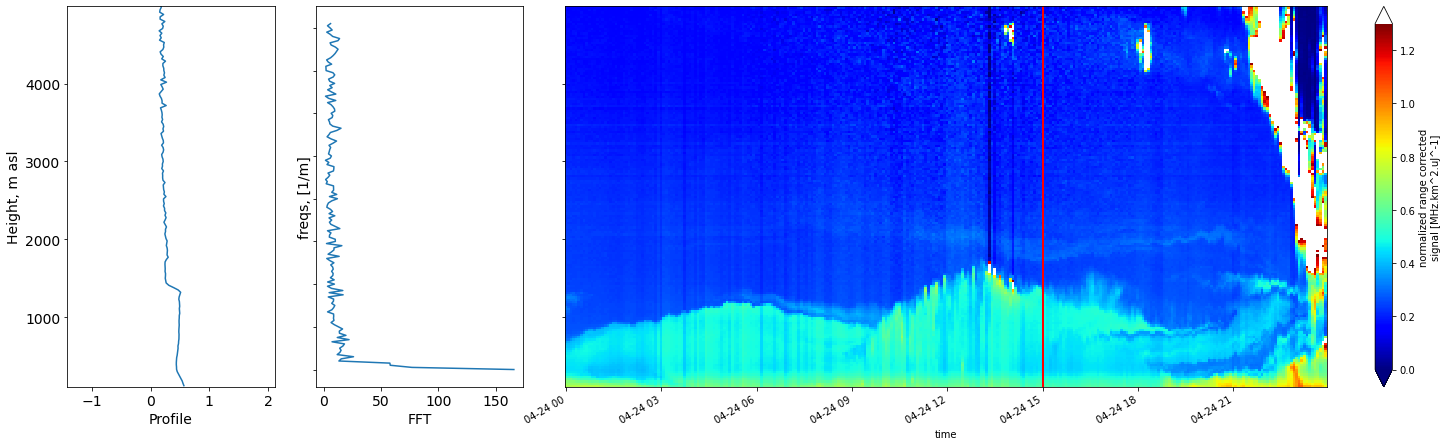

In [ ]:
prf_of_interest = 180

fig, ax = plt.subplots(figsize=[26,7])

ax11 = plt.subplot(1,6,(1))
ax12 = plt.subplot(1,6,(2))
ax2 = plt.subplot(1,6,(3,6), sharey=ax11)


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 2500
fmax = 1/max_range

ds.sel(range=slice(0, 5000)).rcs_0.plot.pcolormesh(y='range', vmin=0, vmax=1.3, cmap='jet', axes=ax2)

endTime = ds.time[prf_of_interest] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 5000, linewidth=2,color='red',fill=False)

ax2.add_patch(rect)

ax11.plot(ds.rcs_0[prf_of_interest], ds.range)

ax12.plot(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, 5000)))]))[prf_of_interest], ds.freqs[0: len(ds.range.sel(range=slice(0, 5000)))])




# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax11.set_xlabel(r'Profile', fontsize=14)
ax11.set_ylabel('Height, m asl', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=14)
ax11.tick_params(axis='both', which='minor', labelsize=14)

ax12.set_xlabel(r'FFT', fontsize=14)
ax12.set_ylabel('freqs, [1/m]', fontsize=14)
ax12.tick_params(axis='both', which='major', labelsize=14)
ax12.tick_params(axis='both', which='minor', labelsize=14)


ax2.set_ylabel('')

o_ = plt.setp(ax2.get_yticklabels(), visible=False)
m_ = plt.setp(ax12.get_yticklabels(), visible=False)

### Transformada de Perfiles y transformada de quicklook

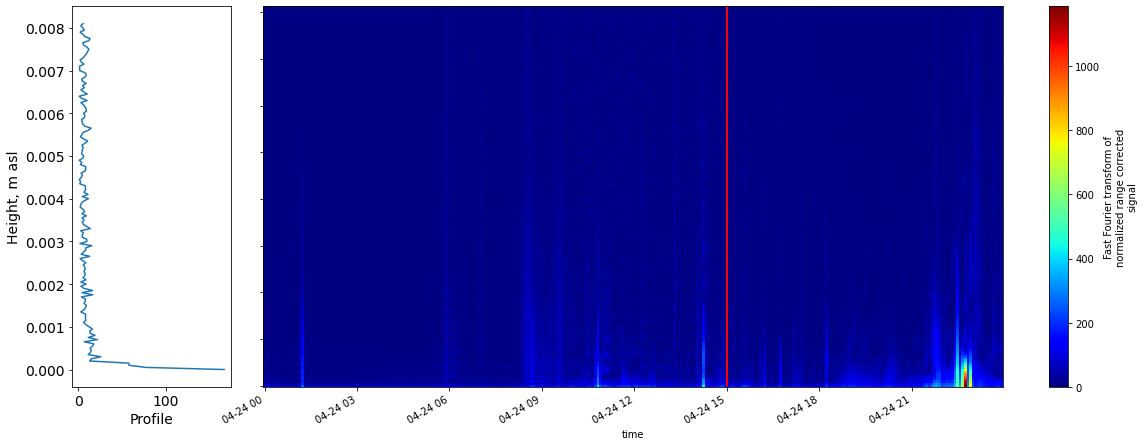

In [ ]:
prf_of_interest = 180

fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))
ax2 = plt.subplot(1,6,(2,6), sharey=ax11)


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 5000

np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])).plot.pcolormesh(y='freqs', vmin=0, vmax=None, cmap='jet', axes=ax2)

endTime = ds.time[prf_of_interest] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)

ax2.add_patch(rect)

ax1.plot(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest], ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])




# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax1.set_xlabel(r'Profile', fontsize=14)
ax1.set_ylabel('Height, m asl', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)

ax2.set_ylabel('')

o_ = plt.setp(ax2.get_yticklabels(), visible=False)
m_ = plt.setp(ax12.get_yticklabels(), visible=False)

### Correlación cruzada de prfiles de línea

(0.0, 100000.0)

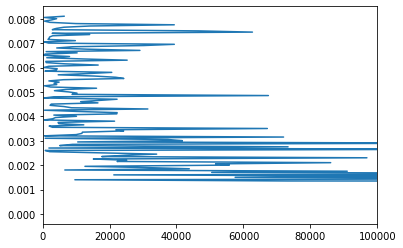

In [ ]:
win_size = 2
# np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0)

plt.plot(np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0), ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])
# plt.ylim([0, 0.002])
plt.xlim([0, 1e5])

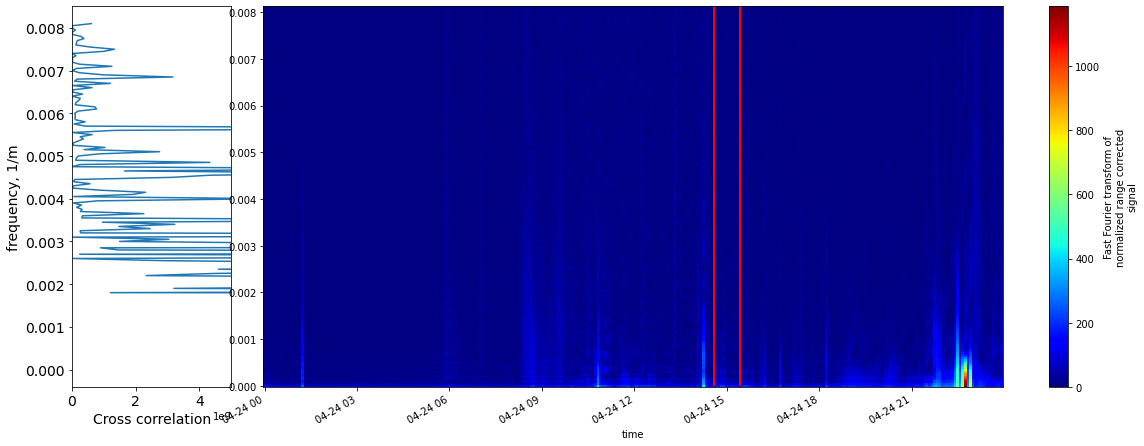

In [ ]:
prf_of_interest = 180
win_size = 5

fig, ax = plt.subplots(figsize=[20,7])

ax1 = plt.subplot(1,6,(1))
ax2 = plt.subplot(1,6,(2,6))


qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


max_range = 5000

np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])).plot.pcolormesh(y='freqs', vmin=0, vmax=None, cmap='jet', axes=ax2)



ax1.plot(np.prod(np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))[prf_of_interest-win_size: prf_of_interest+win_size+1], axis=0), ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))])
ax1.set_xlim([0 ,5e9])
# ax1.set_ylim([0, 0.002])



# pdb.set_trace()


# dataarray_magnitude(ds.rcs_0_fft.sel(freqs=slice(0, len(ds.sel(range=slice(0,50)).range))))
# plt.title('FFT de la señal corregida de rango')

ax1.set_xlabel(r'Cross correlation', fontsize=14)
ax1.set_ylabel('frequency, 1/m', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
ax2.set_ylabel('')

endTime = ds.time[prf_of_interest-win_size] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest-win_size])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

endTime = ds.time[prf_of_interest+win_size] + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[prf_of_interest+win_size])
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, max_range, linewidth=2,color='red',fill=False)
ax2.add_patch(rect)

# o_ = plt.setp(ax2.get_yticklabels(), visible=False)


In [ ]:
np.prod([[1,2]], axis=0)

array([1, 2])

## Normalización

OJO! Verificar la normalización de la altura porque la altura minima puede variar depende del instrumento!

In [ ]:
blh_human_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'

In [ ]:
filenames[-2:]

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

In [ ]:
max_range = 2500
X1 = []
X2 = []
Y = []
for filename in filenames[-2:]:
  ds = xr.load_dataset(filename)
  ds = apply_fft_ds(ds, channel='rcs_0', )

  date = filename.split('/')[-1].split('.')[0].split('_')[-1]
  blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  blh_human = pd.read_csv(blh_human_filename)
  blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)
  mask = np.zeros(ds.rcs_0.shape)
  for idx, profile in enumerate(mask):
    mask[idx] = xr.where(ds.range < blh_human['blh_ref'][idx], 1, 0)
  ds = ds.assign({'abl_mask': (('time', 'range'), mask)})
  
  ds_shape = ds.rcs_0.sel(range=slice(0,max_range)).shape

  lidar_fft = np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))


  X1.append(normalize_ds(lidar_fft, vectorize_flag=False).values)
  X2.append(normalize_ds(ds.sel(range=slice(0, max_range)).rcs_0, vectorize_flag=False).values)

  Y.append(ds.abl_mask.sel(range=slice(0,max_range)).values)
  # pdb.set_trace()

X1 = np.concatenate((X1))
X2 = np.concatenate((X2))
Y = np.concatenate((Y))


X = np.dstack((X1, X2))



> <ipython-input-246-3b3b1c1d5f3c>(5)<module>()->None
-> for filename in filenames[-2:]:
(Pdb) c
> <ipython-input-246-3b3b1c1d5f3c>(5)<module>()->None
-> for filename in filenames[-2:]:
(Pdb) c


In [ ]:
X.shape, Y.shape

((576, 80, 2), (576, 80))

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.7, shuffle=True)

In [ ]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((403, 80, 2), (403, 80), (173, 80, 2), (173, 80))

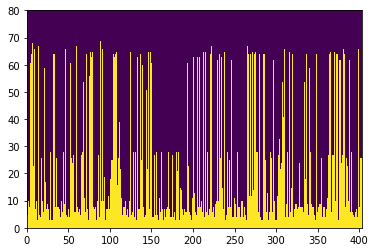

In [ ]:
plt.pcolormesh(Y_train.T)

# Construcción del modelo

In [ ]:
model = models.Sequential()

model.add(tf.keras.Input(shape=(80, 2)))
model.add(tf.keras.layers.Flatten())
model.add(layers.Dense(160, activation='sigmoid'))
model.add(layers.Dense(80, activation='sigmoid'))
model.add(layers.Dense(80, activation='sigmoid'))
# model.add(layers.Dense(30, activation='sigmoid'))
# # model.add(tf.keras.layers.Flatten()) 
# model.add(layers.Dense(10, activation='sigmoid'))
# model.add(layers.Dense(1, activation='linear'))

# model = models.Sequential(
#     [
#         layers.Dense(80, activation="sigmoid", name="layer1"),
#         # layers.Dense(60, activation="sigmoid", name="layer2"),
#         layers.Dense(30, activation="sigmoid", name="layer3"),
#         layers.Dense(1, activation="sigmoid", name="output"),
#     ]
# )
# model.build(input_shape=(80, ))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 160)               0         
                                                                 
 dense_51 (Dense)            (None, 160)               25760     
                                                                 
 dense_52 (Dense)            (None, 80)                12880     
                                                                 
 dense_53 (Dense)            (None, 80)                6480      
                                                                 
Total params: 45,120
Trainable params: 45,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
                    

#Entrenamieto del modelo

In [ ]:
history = model.fit(X_train, Y_train, epochs=1000, validation_data=(X_test, Y_test))

Epoch 1/1000
13/13 [==============================] - 1s 13ms/step - loss: 0.2259 - root_mean_squared_error: 0.4752 - val_loss: 0.1872 - val_root_mean_squared_error: 0.4327
Epoch 2/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1728 - root_mean_squared_error: 0.4157 - val_loss: 0.1570 - val_root_mean_squared_error: 0.3963
Epoch 3/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1535 - root_mean_squared_error: 0.3918 - val_loss: 0.1478 - val_root_mean_squared_error: 0.3844
Epoch 4/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.1478 - root_mean_squared_error: 0.3845 - val_loss: 0.1449 - val_root_mean_squared_error: 0.3807
Epoch 5/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1460 - root_mean_squared_error: 0.3821 - val_loss: 0.1438 - val_root_mean_squared_error: 0.3793
Epoch 6/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.1449 - root_mean_squared_error: 0.3806 - val_loss: 0.1425 - val

# Evaluación

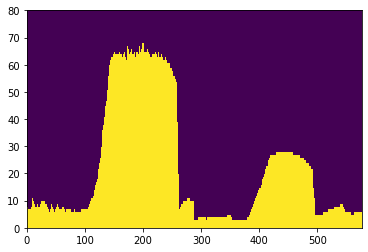

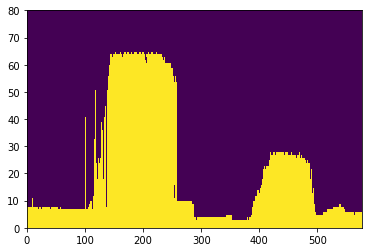

In [ ]:
y_out = model.predict(X)

plt.pcolormesh(Y.T)
plt.show()
plt.pcolormesh(np.rint(y_out.T))

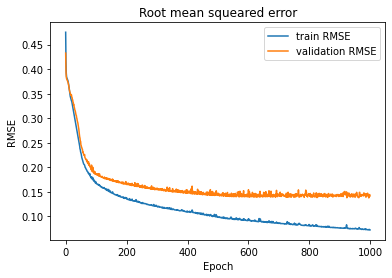

In [ ]:
plt.plot(history.history['root_mean_squared_error'], label='train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Root mean squeared error')
plt.legend()

# Prueba

In [ ]:
filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20170424.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.out.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5030_20200326.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

<class 'numpy.ndarray'>


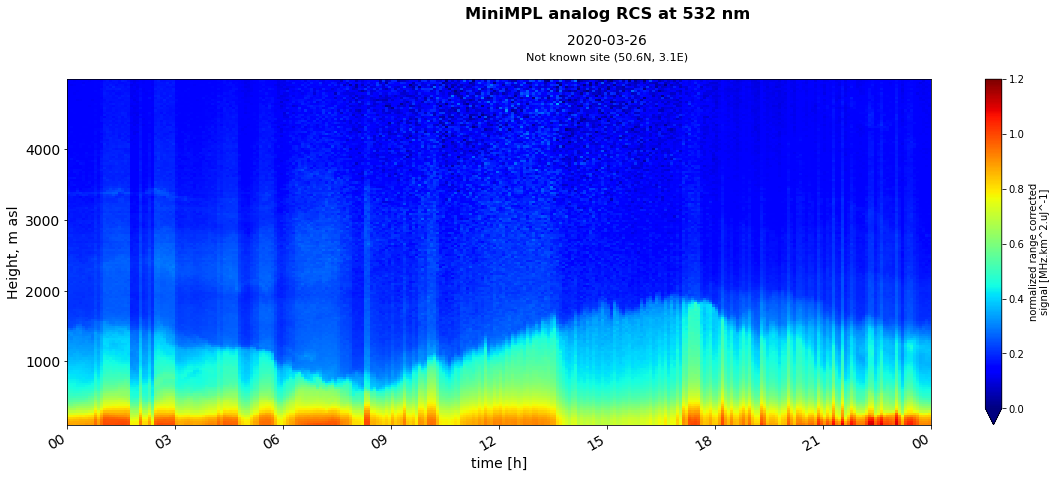

In [ ]:
for filename in [filenames[2]]:
  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range)

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))


  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.2,
            vmin=0,
            )
  
  

  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, m asl', fontsize=14)
  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

In [ ]:
max_range = 2500
X1 = []
X2 = []

ds = apply_fft_ds(ds, channel='rcs_0')

ds_shape = ds.rcs_0.sel(range=slice(0,max_range)).shape

lidar_fft = np.abs(ds.rcs_0_fft.sel(freqs=ds.freqs[0: len(ds.range.sel(range=slice(0, max_range)))]))


X1.append(normalize_ds(lidar_fft, vectorize_flag=False).values)
X2.append(normalize_ds(ds.sel(range=slice(0, max_range)).rcs_0, vectorize_flag=False).values)

# pdb.set_trace()

X1 = np.concatenate((X1))
X2 = np.concatenate((X2))

X = np.dstack((X1, X2))

print(X.shape, X.max(), X.min())

(288, 80, 2) 1.0 0.0


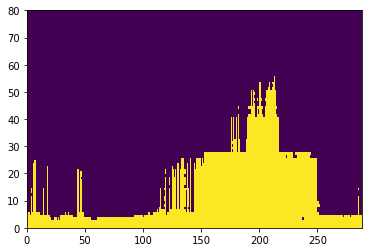

In [ ]:
y_out = model.predict(X)

plt.pcolormesh(np.rint(y_out.T))

<class 'numpy.ndarray'>


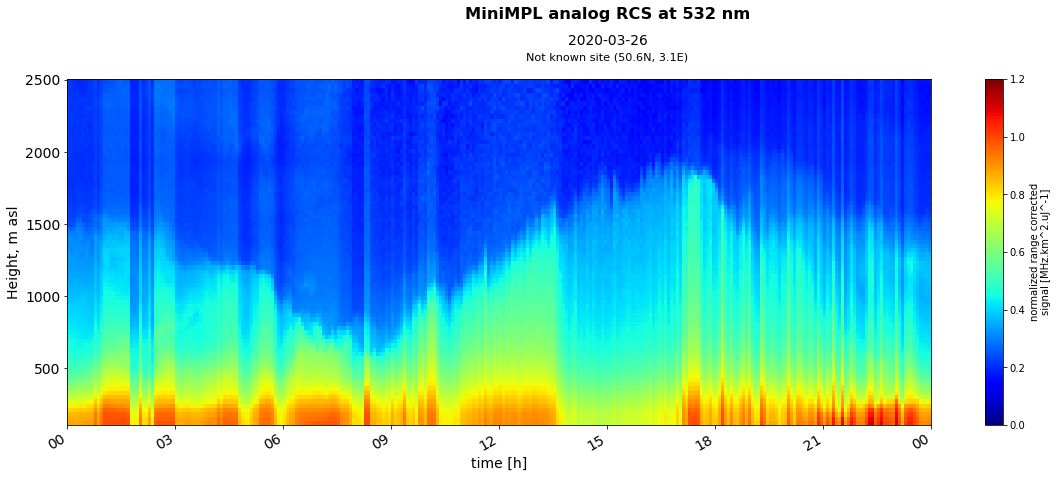

In [ ]:
for filename in [filenames[2]]:
  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range)

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))


  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.2,
            vmin=0,
            )
  
  

  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, m asl', fontsize=14)
  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

  y_out = model.predict(X)

  plt.pcolormesh(np.rint(y_out.T))